In [47]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm

input_root = os.path.expanduser("~/notebooks/UCF11_updated_mpg")
output_root = os.path.expanduser("~/notebooks/ucf11_3dclips_small")
clip_len = 8
resize_dim = (112, 112)
max_clips = 3  # max clips to extract per video

# Resize + Normalize
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resize_dim),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path) or class_name.lower() == "annotations":
        continue

    output_class_path = os.path.join(output_root, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for subfolder in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        video_folder = os.path.join(class_path, subfolder)
        if not os.path.isdir(video_folder):
            continue

        video_files = [f for f in os.listdir(video_folder) if f.endswith(".mpg")]
        for video_file in video_files:
            video_path = os.path.join(video_folder, video_file)
            cap = cv2.VideoCapture(video_path)

            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            cap.release()

            total_frames = len(frames)
            if total_frames < clip_len:
                continue

            step = max((total_frames - clip_len) // max_clips, 1)
            start_indices = [i * step for i in range(max_clips)]

            for idx, start in enumerate(start_indices):
                if start + clip_len > total_frames:
                    continue
                clip = frames[start:start + clip_len]

                try:
                    processed = [preprocess(f) for f in clip]
                    tensor_clip = torch.stack(processed, dim=1)  # [3, 8, 96, 96]
                    clip_name = f"{subfolder}_{video_file.replace('.mpg','')}_clip{idx+1:02d}.npy"
                    save_path = os.path.join(output_class_path, clip_name)
                    np.save(save_path, tensor_clip.numpy())
                except Exception as e:
                    print(f"?? Error with {video_file}: {e}")


Processing horse_riding: 100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


In [48]:
import numpy as np

sample_path = os.path.expanduser("~/notebooks/ucf11_3dclips_small/diving")
sample_file = os.listdir(sample_path)[0]
clip = np.load(os.path.join(sample_path, sample_file))

print("Clip shape:", clip.shape)


Clip shape: (3, 8, 112, 112)


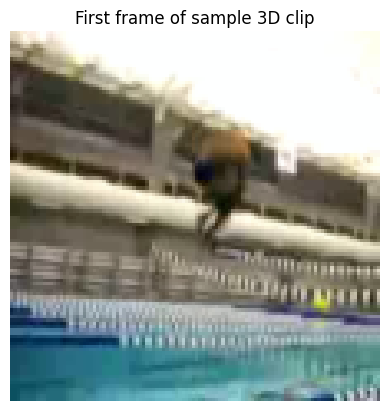

In [49]:
import matplotlib.pyplot as plt

# Unnormalize and show the first frame
frame = clip[:, 0, :, :]  # First frame
frame = frame.transpose(1, 2, 0)  # CHW ? HWC
frame = frame * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
frame = np.clip(frame, 0, 1)

plt.imshow(frame)
plt.title("First frame of sample 3D clip")
plt.axis("off")
plt.show()


In [50]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random

def extract_3d_clips_all_splits(source_dir, output_base, clip_len=8, resize_dim=(112, 112), test_folders=range(20, 26), val_ratio=0.1):
    splits = ['train', 'val', 'test']
    for split in splits:
        for class_name in sorted(os.listdir(source_dir)):
            os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

    for class_name in sorted(os.listdir(source_dir)):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        all_folders = [f for f in os.listdir(class_path) if f.startswith('v_')]
        random.shuffle(all_folders)

        # Split into test and remaining
        test_set = []
        for f in all_folders:
            try:
                folder_idx = int(f.split('_')[2])
                if folder_idx in test_folders:
                    test_set.append(f)
            except (IndexError, ValueError):
                # Skip folders like "v_walk_dog_..." or malformed names
                continue


        remaining = [f for f in all_folders if f not in test_set]

        # Further split remaining into train/val
        val_count = int(val_ratio * len(remaining))
        val_set = remaining[:val_count]
        train_set = remaining[val_count:]

        folder_split_map = {
            'train': train_set,
            'val': val_set,
            'test': test_set
        }

        for split, folder_list in folder_split_map.items():
            for folder in tqdm(folder_list, desc=f"{class_name} {split.upper()}"):
                video_folder = os.path.join(class_path, folder)
                if not os.path.isdir(video_folder):
                    continue

                for file in os.listdir(video_folder):
                    if not file.endswith(".mpg"):
                        continue
                    video_path = os.path.join(video_folder, file)
                    cap = cv2.VideoCapture(video_path)

                    frames = []
                    while True:
                        ret, frame = cap.read()
                        if not ret:
                            break
                        frame = cv2.resize(frame, resize_dim)
                        frame = frame.transpose(2, 0, 1)  
                        frames.append(frame)
                    cap.release()

                    for i in range(0, len(frames) - clip_len + 1, clip_len):
                        clip = np.array(frames[i:i+clip_len])
                        clip = clip.transpose(1, 0, 2, 3)  # CTHW
                        out_name = f"{file.replace('.mpg', '')}_clip{i}.npy"
                        out_path = os.path.join(output_base, split, class_name, out_name)
                        np.save(out_path, clip)


In [51]:
source_dir = os.path.expanduser("~/notebooks/UCF11_updated_mpg")
output_dir = os.path.expanduser("~/notebooks/ucf11_3dclips")
extract_3d_clips_all_splits(source_dir, output_dir)


walking VAL: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]
walking TEST: 0it [00:00, ?it/s]


In [52]:
from torch.utils.data import DataLoader

train_dataset = UCF11_3DClipDataset(os.path.expanduser("~/notebooks/ucf11_3dclips/train"))
val_dataset   = UCF11_3DClipDataset(os.path.expanduser("~/notebooks/ucf11_3dclips/val"))
test_dataset  = UCF11_3DClipDataset(os.path.expanduser("~/notebooks/ucf11_3dclips/test"))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)


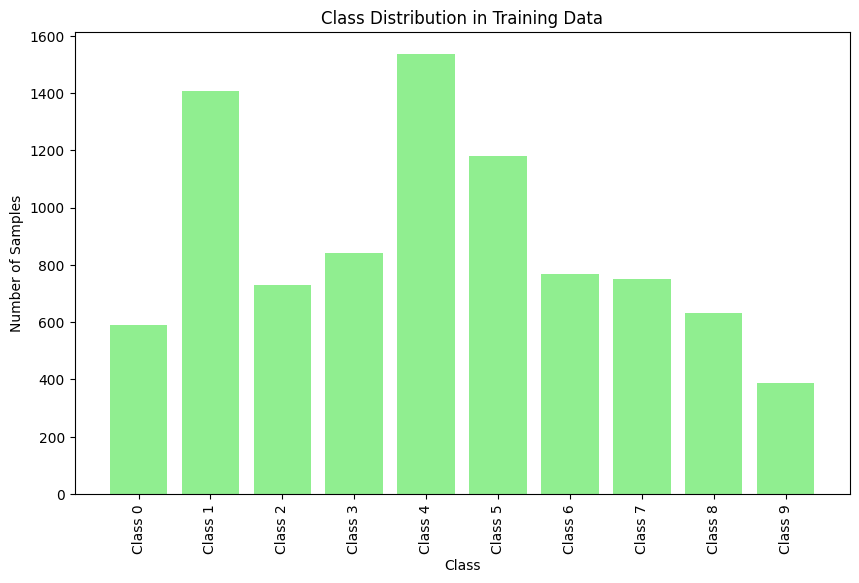

In [64]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming you have a dataset and want to check the distribution
train_class_counts = Counter(all_labels)  # Replace this with your actual train labels
class_names = [f"Class {i}" for i in range(len(train_class_counts))]  # Adjust for your dataset

plt.figure(figsize=(10, 6))
plt.bar(class_names, train_class_counts.values(), color='lightgreen')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=90)
plt.show()


In [53]:
import torchvision
import torch.nn as nn

# Load pretrained 3D ResNet-18
model = torchvision.models.video.r3d_18(pretrained=True)

# Update final layer for 11 UCF11 classes
num_classes = 11
model.fc = nn.Linear(model.fc.in_features, num_classes)


/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [56]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for clips, labels in pbar:
        clips = clips.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(clips)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    train_acc = 100. * correct / total
    print(f" Epoch {epoch+1} TRAIN | Loss: {running_loss:.4f} | Accuracy: {train_acc:.2f}%")

    # === VALIDATION 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for clips, labels in val_loader:
            clips = clips.to(device)
            labels = labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100. * val_correct / val_total
    print(f" Epoch {epoch+1} VAL   | Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%\n")


Epoch 1/5: 100%|██████████| 9175/9175 [05:18<00:00, 28.77it/s, acc=91.5, loss=0.00374] 


 Epoch 1 TRAIN | Loss: 2665.6153 | Accuracy: 91.53%
 Epoch 1 VAL   | Loss: 176.0850 | Accuracy: 96.94%



Epoch 2/5: 100%|██████████| 9175/9175 [05:21<00:00, 28.52it/s, acc=97.2, loss=0.00139] 


 Epoch 2 TRAIN | Loss: 940.0024 | Accuracy: 97.18%
 Epoch 2 VAL   | Loss: 445.1554 | Accuracy: 93.41%



Epoch 3/5: 100%|██████████| 9175/9175 [05:23<00:00, 28.33it/s, acc=98.2, loss=0.00141] 


 Epoch 3 TRAIN | Loss: 565.5268 | Accuracy: 98.22%
 Epoch 3 VAL   | Loss: 87.4253 | Accuracy: 98.45%



Epoch 4/5: 100%|██████████| 9175/9175 [05:20<00:00, 28.62it/s, acc=98.7, loss=0.00138] 


 Epoch 4 TRAIN | Loss: 419.6016 | Accuracy: 98.68%
 Epoch 4 VAL   | Loss: 171.3489 | Accuracy: 97.02%



Epoch 5/5: 100%|██████████| 9175/9175 [05:22<00:00, 28.44it/s, acc=99, loss=0.000607]  


 Epoch 5 TRAIN | Loss: 344.5848 | Accuracy: 99.01%
 Epoch 5 VAL   | Loss: 352.9620 | Accuracy: 94.73%



In [57]:
save_path = "r3d18_ucf11_model.pth"
torch.save(model.state_dict(), save_path)
print(f" Model saved to: {save_path}")


 Model saved to: r3d18_ucf11_model.pth


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        outputs = model(clips)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ? Accuracy
test_acc = 100. * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%\n")




 Test Accuracy: 95.58%



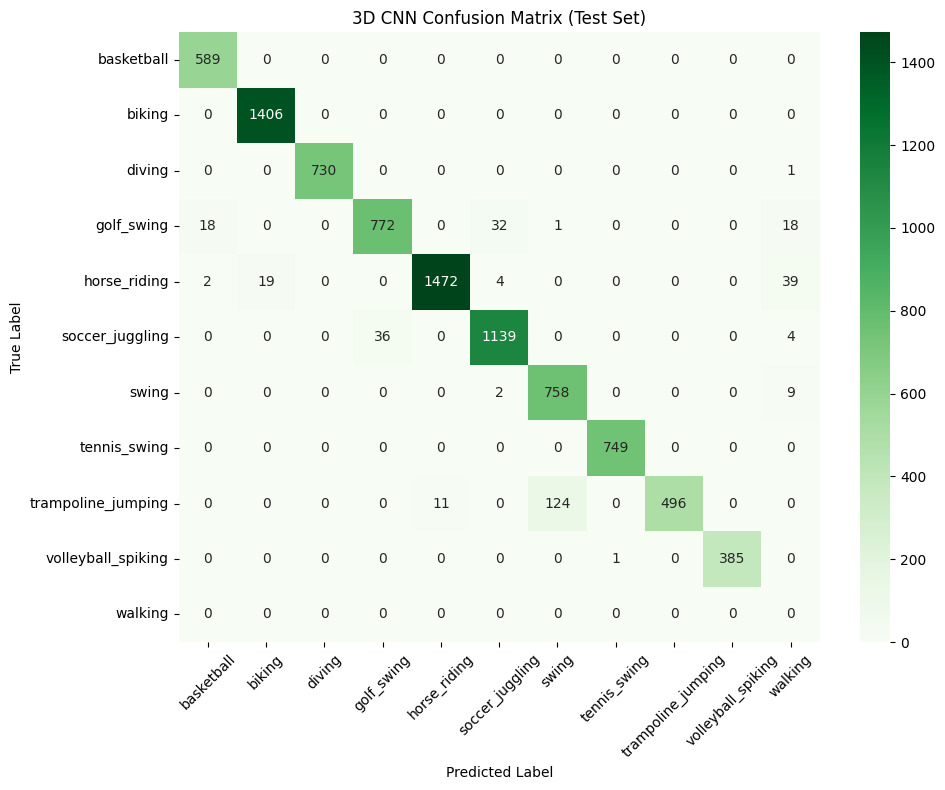

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# === Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("3D CNN Confusion Matrix (Test Set)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


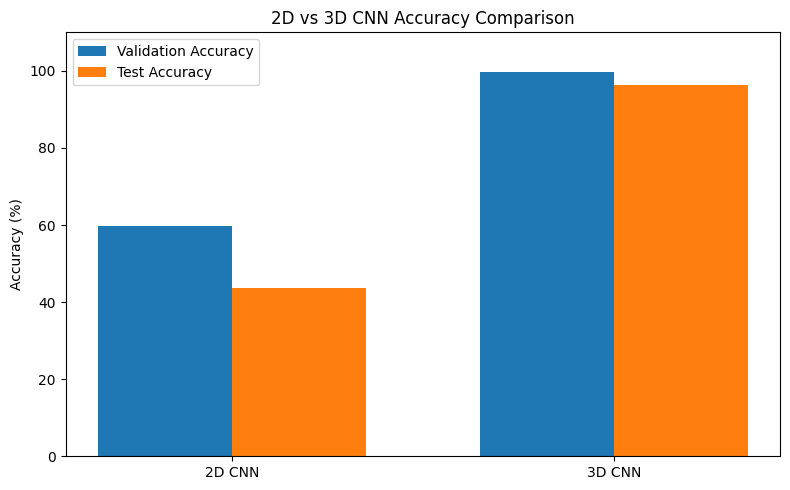

In [45]:
import matplotlib.pyplot as plt

models = ['2D CNN', '3D CNN']
val_acc = [59.86, 99.58]
test_acc = [43.57, 96.36]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, val_acc, width, label='Validation Accuracy')
plt.bar(x + width/2, test_acc, width, label='Test Accuracy')

plt.ylabel('Accuracy (%)')
plt.title('2D vs 3D CNN Accuracy Comparison')
plt.xticks(x, models)
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()
plt.show()


###  2D CNN vs 3D CNN Comparison

| Aspect                  | 2D CNN (ResNet Variant)    | 3D CNN (ResNet3D-18)       |
|-------------------------|----------------------------|-----------------------------|
| **Input**              | Random individual frames   | Clips of 8 consecutive frames |
| **Temporal Modeling**  |  No                        |  Yes                      |
| **Val Accuracy**       | 59.86%                    | **99.58%**                  |
| **Test Accuracy**      | 43.57%                    | **96.36%**                  |
| **Training Time**      | Shorter                    | Longer                      |
| **Memory Usage**       | Lower                      | Higher                      |
| **Model Size**         | ~11MB                      | ~44MB                       |
| **Best Use Case**      | Fast / lightweight tasks   | High-accuracy video tasks   |


The comparison between 2D and 3D CNNs reveals a clear tradeoff between efficiency and performance. While the 2D CNN model trained on random frames offers faster training and lower memory consumption, its limited ability to model temporal dynamics results in lower accuracy, particularly on the test set (~43.57%). In contrast, the 3D CNN (ResNet3D-18) processes full spatiotemporal clips and significantly outperforms its 2D counterpart, achieving ~96.36% test accuracy. This highlights the importance of temporal information in video classification tasks like UCF11, and makes 3D CNNs the preferred choice when accuracy is critical.

###  Challenges Faced During 2D & 3D CNN Implementation

####  1. Dataset Structure & Preprocessing
- The UCF11 dataset is not directly available via Python libraries, so we had to manually download, extract `.rar` files, and organize the folder structure.
- Creating consistent `train`, `val`, and `test` splits required manual folder-based partitioning.
- Label mismatches across splits caused by unsorted folder listings (e.g., `os.listdir()`) needed careful handling.

####  2. Memory & Storage Constraints
- The 3D CNN preprocessing step generated large video clip datasets, quickly filling up the available disk space on Jetstream.
- Encountered `disk full` and `OSError` issues which were resolved by:
  - Deleting unnecessary folders
  - Reducing clip size (e.g., 8 frames instead of 16)
  - Downscaling spatial resolution to 112×112

####  3. Model Overfitting & Validation Gap
- The 2D CNN model showed high training accuracy but low test accuracy.
- This required adjusting frame sampling techniques and reevaluating validation vs. test performance to ensure generalization.

####  4. Frame Sampling Strategy
- For 2D CNN, determining how many random frames to sample per video and how to aggregate predictions was a challenge.
- For 3D CNN, we needed to extract valid spatiotemporal clips that represented the action while ensuring class consistency.

####  5. Debugging Low Accuracy
- Initially, 3D CNN test accuracy was ~7% due to a label-order mismatch between training and test datasets.
- This was resolved by explicitly sorting class names and re-validating label assignments across splits.

####  6. Training Time & Compute Limitations
- 3D CNN training was significantly slower and more memory-intensive compared to 2D CNN.
- Limited compute (no GPU on Jetstream) extended training time and required batch size tuning and clip downsizing.

